In [205]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


# Innovation Evaluation 
## Explanatory Notes

* Assignee: Entity Assigned TO
* Assignor: Entity Assigned FROM
* exec_dt: Execution Date between Entities
* grant_doc_num: Granted Patent Document USPTO Number

*Patent is transfered from assignor to assignee*

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
import dill
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from matplotlib import rc
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from ipywidgets import *
from IPython.display import display
from IPython.display import clear_output
import datetime


font = {'color':  'black',
        'weight': 'normal',
        'size': 10,
        'style': 'italic'
        }

matplotlib.rcParams.update({'font.family': 'sans-serif','font.sans-serif': 'Arial', 'mathtext.fontset': 'stix',
                           'font.size':'12'})
matplotlib.rcParams['axes.linewidth'] = 1.3
formatter = ticker.ScalarFormatter(useMathText=True)

In [3]:
body = pd.read_csv('ee_or_matched.csv',index_col=0, dtype=str)

In [4]:
# daily patent assignment number
dategroup = body[['exec_dt','ee_name_matched']]
date_numofass = dategroup.groupby('exec_dt').count().reset_index()
year = [date.split('-', 1)[0] for date in date_numofass['exec_dt']]
date_numofass['exec_dt'] = year
# yearly patent assignment number
yearlydata = date_numofass.groupby('exec_dt').sum().reset_index()

In [5]:
# filter data by year:
# body: the dataframe to be filtered 
# col_name: the name of the date column

def data_by_year(df, min_year, max_year, col_name='exec_dt'):
    lower = df[pd.to_datetime(df[col_name])>pd.to_datetime(min_year)]
    data = lower[pd.to_datetime(lower[col_name])<pd.to_datetime(max_year)]
    return data


def top_group(body, groupbyname, sortbyname, topnum):
    raw = body[[groupbyname, sortbyname]].groupby(groupbyname).count()
    top = raw.sort_values(by=sortbyname, ascending=False)[:topnum]
    return top


def update_data_year(*args):
    data_year = data_by_year(body, 
                             min_year=str(slider.value[0]), 
                             max_year=str(slider.value[1]))
    return data_year


def plot_by_range(df, min_year, max_year):
    body_filtered = data_by_year(df, min_year, max_year)
    x = list(body_filtered.iloc[:,0].astype(int))
    y = list(body_filtered.iloc[:,1])
        
    plt.figure(figsize=(8,4))
    plt.bar(x,y)
    plt.xlabel('Year')
    plt.ylabel('No. Patent Assignment')
    plt.title('Number of Patent Assignment by Year')
    plt.grid(True)
    
def update_plot_by_range(*args):
    clear_output()
    plot_by_range(df, min_year=str(slider.value[0]), max_year=str(slider.value[1]))

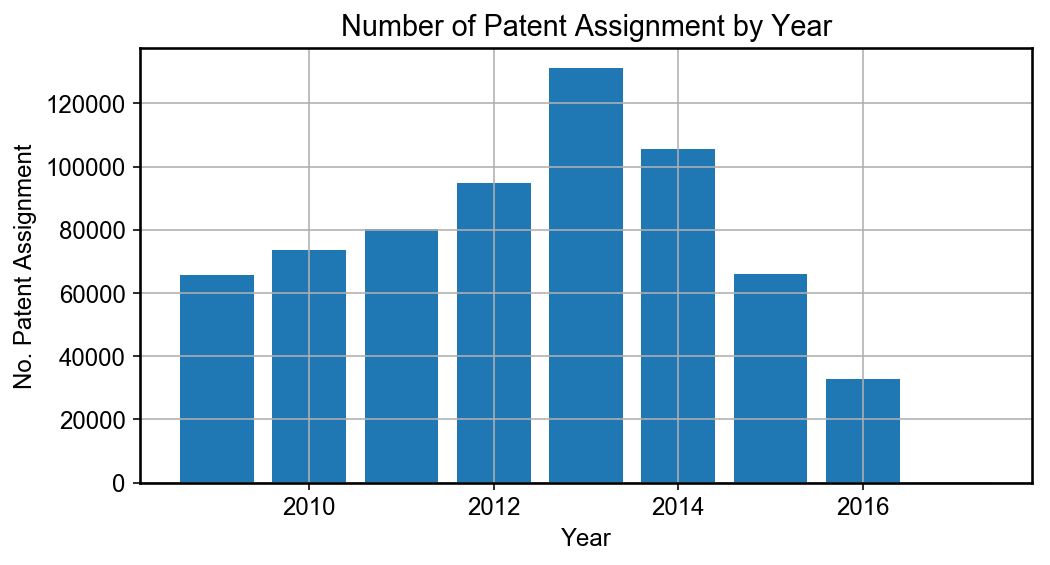

In [6]:
slider = widgets.IntRangeSlider(
    value=[2008, 2018],
    min=1954,
    max=2018,
    step=1,
    description='Year Range:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='i',
    slider_color='white',
    color='black',
    layout={'width': '60%'}
)

df = yearlydata
plot_by_range(df, min_year='2008', max_year='2018')
slider.observe(handler=update_plot_by_range, names='value')

display(slider)

# Study by Year
## Group by Sector


In [7]:
## generate the ticker list in this time range
slider.observe(handler=update_data_year, names='value')
data_year = update_data_year()

## specify top how many sectors you want to look at?
tops = top_group(data_year, 'ticker', 'grant_doc_num', None)
tickerlist = list(tops.index)

In [8]:
## reading in the company information to match this year - from yahoo 
# company_info = pd.read_csv('companylist.csv', usecols=['Symbol','Sector', 'Industry'])
# company_info['Sector'] = company_info['Sector'].replace('Health Care','Healthcare').replace('Financial','Finance')


# updated data source:
company_info = pd.read_csv('companytickers.csv', usecols=['Ticker','Sector', 'Industry'])

In [9]:
## extract company info combine with 
# company_info_use = company_info[company_info['Symbol'].isin(tickerlist)]
# joined_data = company_info_use.rename(columns={'Symbol':'ticker'}).join(tops, on='ticker')

# updated data source:
company_info_use = company_info[company_info['Ticker'].isin(tickerlist)]
joined_data = company_info_use.rename(columns={'Ticker':'ticker'}).join(tops, on='ticker')

groupbysec = pd.DataFrame(joined_data.groupby(['Sector'])['grant_doc_num'].sum())
groupbysec = groupbysec.sort_values(by='grant_doc_num',ascending=False).reset_index()
sectorlist = list(groupbysec['Sector'])
sectornum = list(groupbysec['grant_doc_num'])

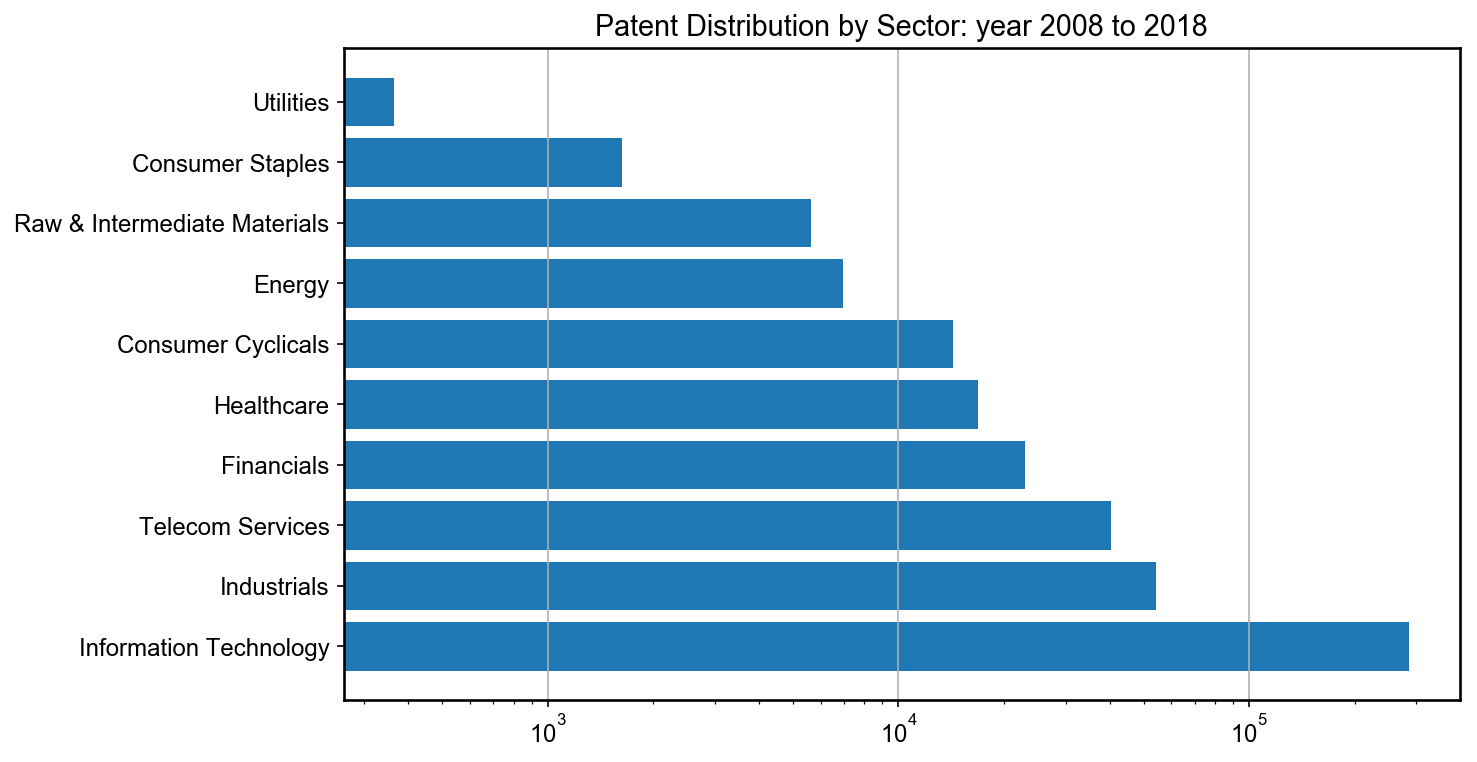

In [10]:
plt.figure(figsize=(10,6))
plt.barh(np.arange(len(sectorlist)), sectornum, align='center')
plt.xscale('log')
plt.yticks(np.arange(len(sectorlist)), sectorlist);
plt.grid(which='major', axis='x')
plt.title('Patent Distribution by Sector: year {} to {}'.format(slider.value[0], slider.value[1]));

# Sector Companies Patent Assignment Info

In [216]:
# need input of top companies to see
def sector_plot(data_year, sector, topnum):
    sec_tickers = list(company_info[company_info['Sector']==sector]['Ticker'])
    sectordf = data_year[data_year['ticker'].isin(sec_tickers)]
    topgroup = top_group(sectordf, 'ticker', 'grant_doc_num', topnum)
    topgroup = topgroup.reset_index()
    x = list(topgroup.iloc[:,0])
    y = list(topgroup.iloc[:,1])
    if len(x)<=5:
        plt.figure(figsize=(5,3))
    if 5<len(x)<=10:
        plt.figure(figsize=(8,4))
    if 10<len(x)<=20:
        plt.figure(figsize=(12,8))
    if len(x)>20:
        plt.figure(figsize=(12,14))
    plt.barh(-np.arange(len(x)), y, height=0.5, align='center')
    plt.xscale('log')
    plt.yticks(-np.arange(len(x)), x);
    plt.grid(which='both', axis='x')
    plt.title('Patent Distribution: {} year {} to {}'.format(sector, slider.value[0], slider.value[1]))
    
def update_sector_plot(*args):
    clear_output()
    sector_plot(data_year, sector=select_sector.value[0], topnum=topnum.value)

In [217]:
def update_companylist(*args):
    sec_tickers = list(company_info[company_info['Sector']==select_sector.value[0]]['Ticker'])
    sectordf = data_year[data_year['ticker'].isin(sec_tickers)]
    companylist = list(top_group(sectordf, 'ticker', 'grant_doc_num', topnum.value).index)
    return companylist

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


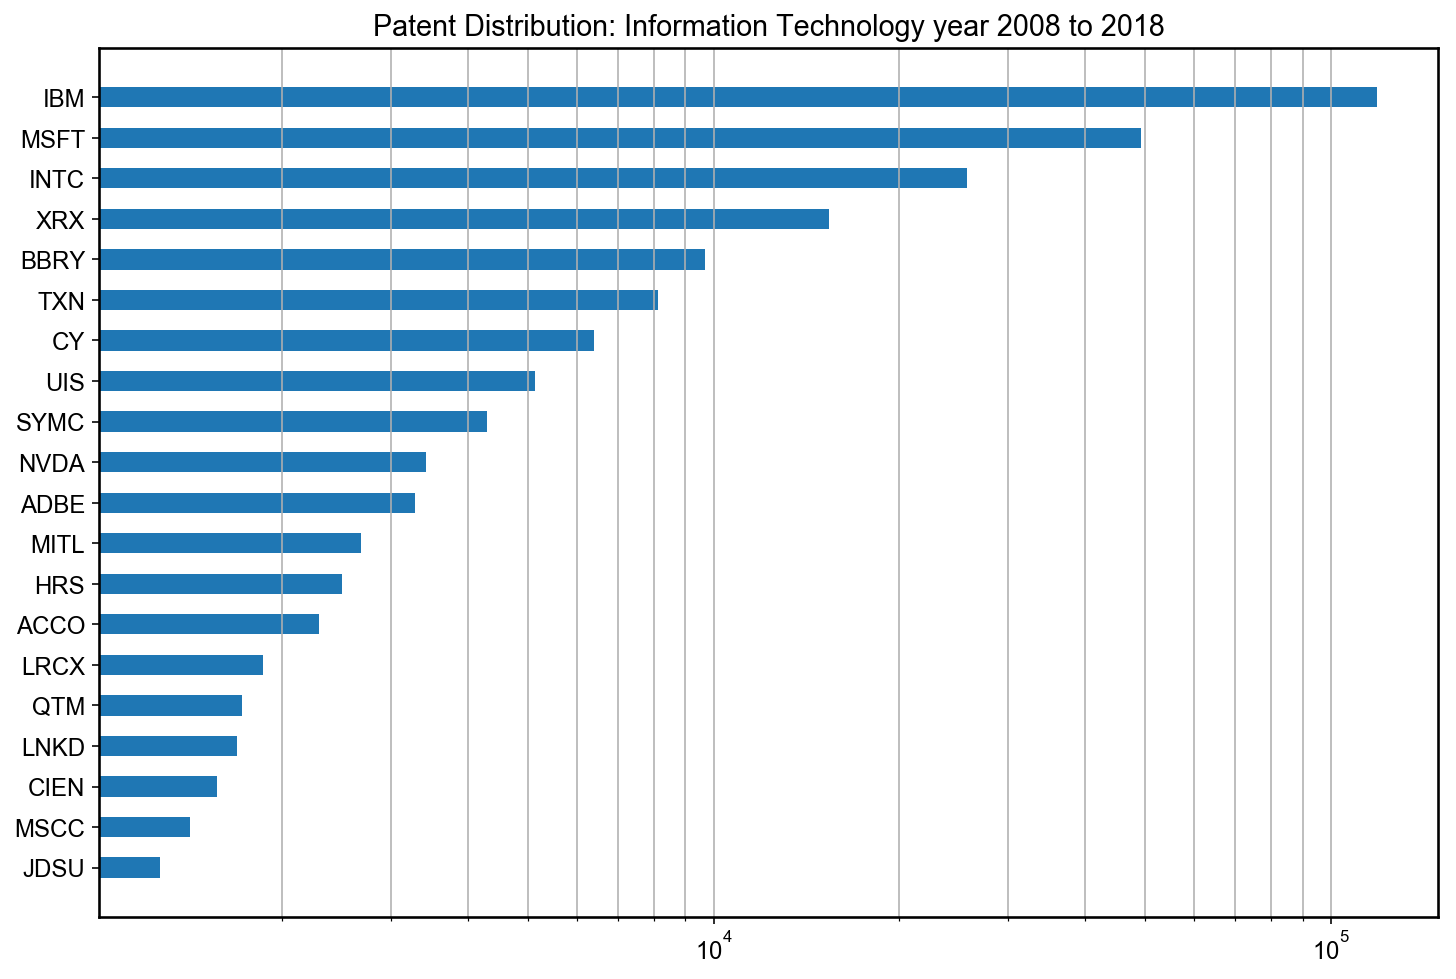

In [218]:
topnum = widgets.IntSlider(min=0,
                           max=50,
                           step=2,
                           value=20,
                           description='Top Companies to Show:',
                           disabled=False,
                           continuous_update=True,
                           orientation='horizontal',
                           readout=True,
                           readout_format='d',
                           layout={'width': '50%'})

select_sector = widgets.SelectMultiple(options=sectorlist, 
                                       value=(sectorlist[0],),
                                       description='Select Sector:',
                                       disabled=False)


select_sector.observe(handler=update_sector_plot, names='value')
topnum.observe(handler=update_sector_plot, names='value')
select_sector.observe(handler=update_companylist, names='value')
topnum.observe(handler=update_companylist, names='value')
companylist = update_companylist()

sector_plot(data_year, sectorlist[0], 20)

display(topnum)
display(select_sector)

# Companies' Patent Assignment and Stock Price

In [219]:
# body: dataframe to be calculated from, usually already filtered by 'data_by_year'
min_yr = str(slider.value[0])
max_yr = str(slider.value[1])

def get_daily_patentnum(body, ticker, groupbyname='exec_dt', sortbyname='grant_doc_num'):
    company = body[body['ticker']==ticker]
    company_use = company.drop(['ee_address_1','ee_address_2','ee_city','ee_state','ee_postcode','ee_country','or_name_matched'],axis=1)
    daily_num = company_use[[sortbyname, groupbyname]].groupby(groupbyname).count().reset_index()
    daily_num2 = data_by_year(daily_num, min_yr, max_yr, col_name='exec_dt')
    time = list(pd.to_datetime(daily_num2[daily_num.columns[0]]))
    patentnum = list(daily_num2[sortbyname])
    
    return (time, patentnum)

def get_stock_data(ticker, y_min, y_max, temp):
    if ticker in temp:
        return (temp[ticker],0)
    else:
        api_url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={}&outputsize=full&apikey=8DZ1S71GQ2XPK9JD'.format(ticker)
        session = requests.Session()
        session.mount('http://', requests.adapters.HTTPAdapter(max_retries=3))
        raw_data = session.get(api_url)
        txt = raw_data.json()
        data = pd.DataFrame(txt['Time Series (Daily)']).T.reset_index()
        data = data[['index','5. adjusted close']]
        data.columns=['date', 'adj. close']
        data = data.sort_values("date", ascending=True)

        dates = pd.to_datetime(data['date'])
        lowerbd_st = data[data['date']>y_min]
        stock_price = lowerbd_st[lowerbd_st['date']<y_max]
        temp[ticker] = stock_price
        return (stock_price, temp)    

def two_scales(ax1,time1,data1,time2,data2,ticker,interval=30):
    ax2 = ax1.twinx()

    ax1.bar(time1, data1, color='r', width=interval, label='#patent')
    ax1.set_xlabel('time')
    ax1.set_ylabel('number of patent')
    ax1.set_title(ticker)
    ax1.legend(loc='best')

    ax2.plot(time2, data2, color='b', label='stock price', linewidth=1)
    ax2.set_ylabel('stock price')
    ax2.legend(loc='lower left')
    return ax1, ax2

def plot_stocknpatent(body, ticker, min_yr, max_yr, interval, temp):
    (x,y)=get_daily_patentnum(body, ticker=ticker)
    stockdf = get_stock_data(ticker=ticker, y_min=str(min_yr), y_max=str(max_yr), temp=temp)[0]
    stockx = list(stockdf[stockdf.columns[0]])
    stockx = pd.to_datetime(stockx)
    stocky = list(stockdf[stockdf.columns[1]])
    stocky = list(map(float, stocky))
    fig, ax = plt.subplots(figsize=(10,4))
    ax1, ax2 = two_scales(ax, x, y, stockx, stocky, ticker=ticker, interval=interval)
    
def update_plot_stocknpatent(*args):
    clear_output()
    plot_stocknpatent(body, dropdown.value, min_yr, max_yr, 30, temp)


In [220]:
# run once to initiate if previous record are gone
# temp = dict()

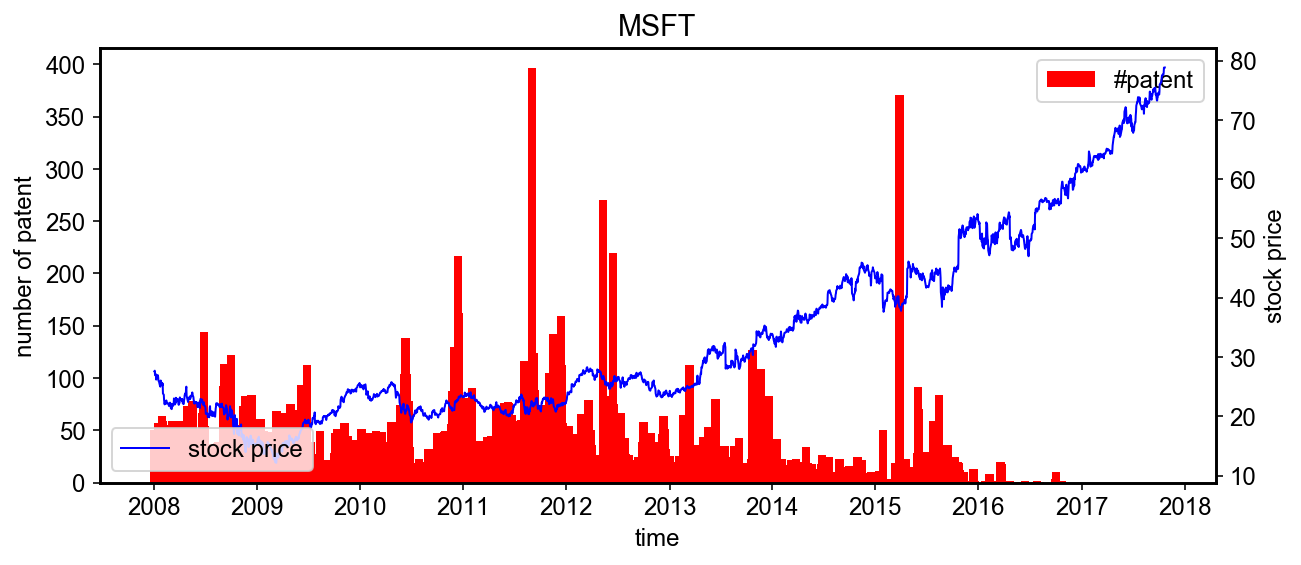

In [221]:
# companylist
dropdown = widgets.Dropdown(options=companylist, description='Company Ticker')
dropdown.observe(handler=update_plot_stocknpatent, names='value')

display(dropdown)